### Clasificación de Noticias Usando RNNs y LSTMs 

#### Librerías

In [11]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#### 1. Carga y Exploración de Datos

In [12]:
Df = pd.read_excel("C:/Users/USER/OneDrive - universidadean.edu.co/5. NLP/Repositorio NLP/Actividad 2/Noticias.xlsx", engine='openpyxl')
Df.drop('Columna1', axis=1, inplace=True)
Df

,Enlaces,Título,info,contenido,Etiqueta
0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo
2,https://www.eltiempo.com/archivo/documento/CMS...,'Me atracaron y vi un arma que me heló la sang...,Un ciudadano relata cómo cuatro hombres lo rob...,A las 7 de la noche me había quedado de encont...,archivo
3,https://www.eltiempo.com/archivo/documento/CMS...,"Escoltas mal estacionados, dolor de cabeza de ...",Las zonas de restaurantes se convierten en par...,Atravesados. Eso es lo que se les pasa por la ...,archivo
4,https://www.eltiempo.com/archivo/documento/CMS...,Radicado primer proyecto que autorizaría union...,"El representante de 'la U', Miguel Gómez, dijo...",“Estamos proponiendo la figura de un contrato ...,archivo
...,...,...,...,...,...
14391,https://www.eltiempo.com/vida/viajar/una-viaje...,Una viajera pensó que la aerolínea Viva Air le...,La mujer hizo la denuncia en redes. La aerolín...,En Twitter es tendencia 'FCAS' por una denunci...,vida
14392,https://www.eltiempo.com/vida/viajar/un-dia-pe...,"Un día perfecto en Coco Cay, la isla privada d...",El proyecto Global Private Island Collection c...,La naviera internacional Royal Caribbean prese...,vida
14393,https://www.eltiempo.com/vida/viajar/visitar-b...,Barú: el paraíso colombiano abierto para todos...,Cuatro hoteles y el Aviario Nacional lanzarán ...,¿Necesita razones para ir a Barú? A menos de u...,vida
14394,https://www.eltiempo.com/vida/viajar/we-trade-...,"Con WeTrade, llega la hora LGBT a Bogotá",El 1 y 2 de noviembre se celebrará esta Feria ...,Se estima que la población LGTBI en Colombia e...,vida


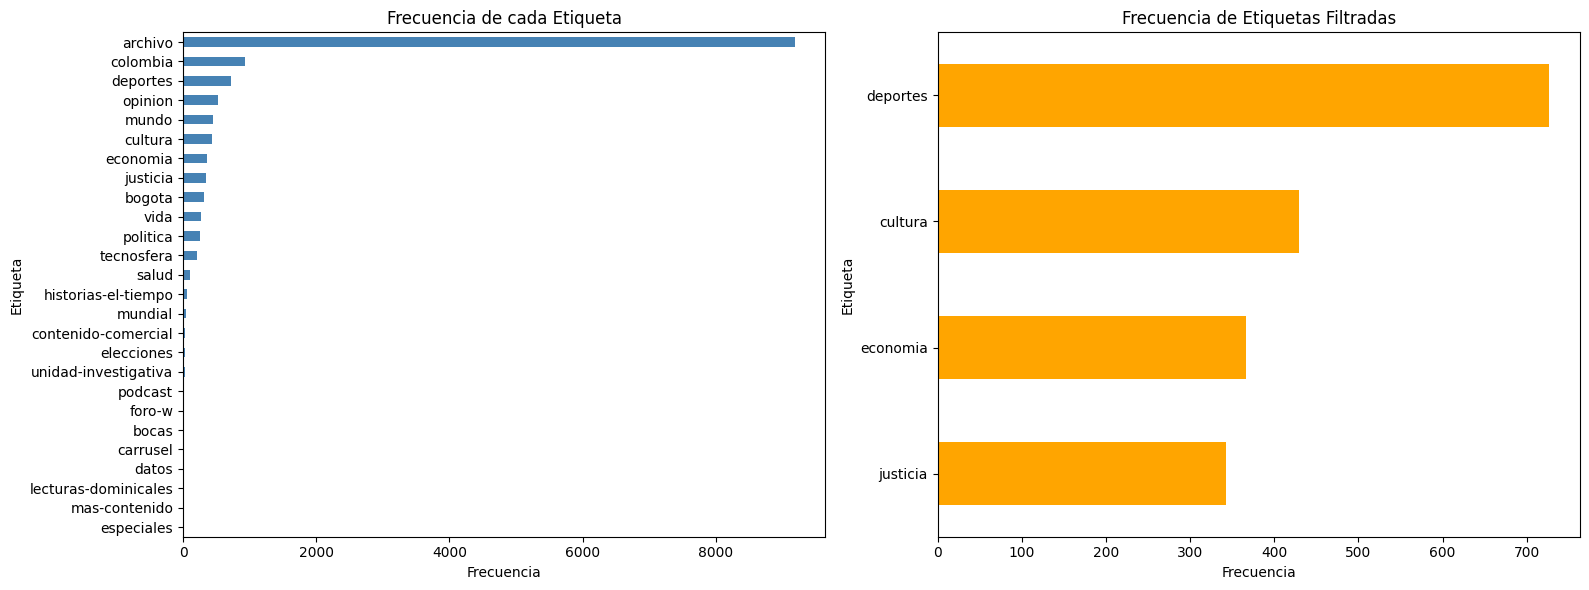

In [13]:
# Calcular las frecuencias
frecuencia_etiquetas = Df['Etiqueta'].value_counts()

# Crear los subgráficos en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Graficar las frecuencias generales
frecuencia_etiquetas.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Frecuencia de cada Etiqueta')
axes[0].set_xlabel('Frecuencia')
axes[0].set_ylabel('Etiqueta')
axes[0].invert_yaxis()  # Invertir el eje Y

# Filtrar etiquetas
Df_filter = Df[Df['Etiqueta'].isin(["deportes", "cultura", "economia", "justicia"])]
frecuencia_etiquetas_filter = Df_filter['Etiqueta'].value_counts()

# Graficar las frecuencias filtradas
frecuencia_etiquetas_filter.plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Frecuencia de Etiquetas Filtradas')
axes[1].set_xlabel('Frecuencia')
axes[1].set_ylabel('Etiqueta')
axes[1].invert_yaxis()  # Invertir el eje Y

# Ajustar diseño para evitar solapamientos
plt.tight_layout()
plt.show()



#### 2. Filtrado de Datos

In [14]:
#Eliminar contenido vacio
Df_filter = Df_filter.dropna(subset=['contenido'])

# Tomar 300 comentarios de cada etiqueta
#Df_filter = Df_filter.groupby('Etiqueta').head(300)
Df_filter


,Enlaces,Título,info,contenido,Etiqueta
10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura
10489,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura
10490,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura
10491,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura
...,...,...,...,...,...
12467,https://www.eltiempo.com/justicia/servicios/po...,Más de 70 mil policías apoyan jornada de aisla...,Miisterio de Defensa activó dispositivo especi...,"El ministro de la Defensa, Carlos Holmes Truj...",justicia
12468,https://www.eltiempo.com/justicia/servicios/pr...,Habrá proyecto conjunto para superar la crisis...,Se revisarán “conductas antisociales” que se h...,Después de varios contrapunteos sobre la mejor...,justicia
12469,https://www.eltiempo.com/justicia/servicios/qu...,¿Qué hacer en caso de un accidente de tránsito...,EL TIEMPO y la Unilibre responden a esta y otr...,El TIempo y la Universidad Libre se aliaron pa...,justicia
12470,https://www.eltiempo.com/justicia/servicios/su...,Otorgan subsidios a tres obreros del edificio ...,También la esposa de una de las víctimas recib...,Tres trabajadores del edificio Portales Blas d...,justicia


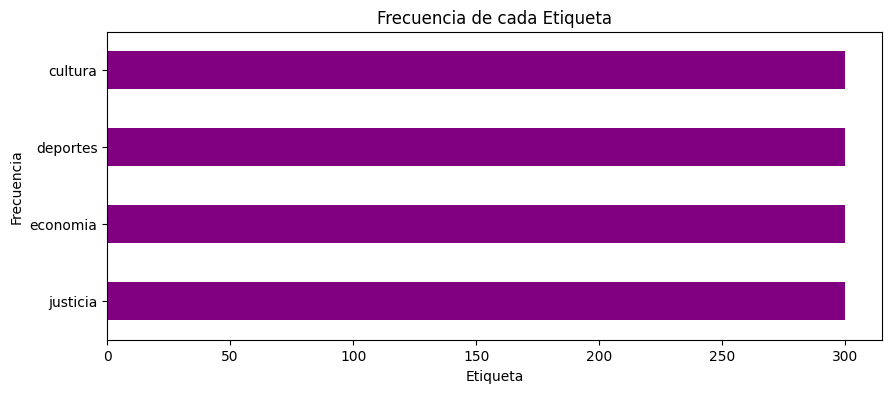

In [15]:
# Primeros 300 datos por etiqueta
Df_filter=Df_filter.groupby('Etiqueta').head(300)

#Graficar frecuencia
frecuencia_etiquetas = Df_filter['Etiqueta'].value_counts()

plt.figure(figsize=(10, 4))
frecuencia_etiquetas.plot(kind='barh', color='purple')
plt.title('Frecuencia de cada Etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.gca().invert_yaxis()
plt.show()

#### 3. Preprocesamiento

In [16]:

# Crear una copia de Df_filter para Df_pre
Df_pre = Df_filter.copy()

Df_pre



,Enlaces,Título,info,contenido,Etiqueta
10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura
10489,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura
10490,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura
10491,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura
...,...,...,...,...,...
12424,https://www.eltiempo.com/justicia/investigacio...,Duque promete sanciones ejemplares a quienes h...,El mandatario habló tras investigación de Sema...,“Aquí hay cero tolerancia con cualquier miembr...,justicia
12425,https://www.eltiempo.com/justicia/investigacio...,¿Qué hay contra los dos generales investigados...,Procuraduría busca determinar si tomaron medid...,Por los hechos relacionados con el atentado a ...,justicia
12426,https://www.eltiempo.com/justicia/investigacio...,Reclutador de 'falsos positivos' se retracta e...,Alexander Carretero dice que aceptó la respons...,"Alexander Carretero Díaz, uno de los principal...",justicia
12427,https://www.eltiempo.com/justicia/investigacio...,Recuperan respirador artificial que había sido...,Se trata de un equipo biomédico para el tratam...,La Policía Nacional informó que miembros de es...,justicia


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
import spacy
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

nltk.download('stopwords')

# Cargar modelo de SpaCy
nlp = spacy.load('es_core_news_sm')

# 1. Clase para Normalizar el texto
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))

    def normalize_text(self, text):
        text = text.lower()
        text = re.sub(r"[.,!?]", r" \g<0> ", text)  # Espacios antes y después de puntuación
        text = re.sub(r"[\W\d_]+", " ", text)  # Eliminar caracteres especiales y números
        text = " ".join([word for word in text.split() if word not in self.stop_words])  # Remover stopwords
        return text.strip()

    def transform(self, X, **kwargs):
        return X.apply(self.normalize_text)

    def fit(self, X, y=None, **kwargs):
        return self

# 2. Clase para Lematizar el texto
class TextLemmatizer(BaseEstimator, TransformerMixin):
    def transform(self, X, **kwargs):
        return X.apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

    def fit(self, X, y=None, **kwargs):
        return self

# 3. Clase para Tokenizar el texto
class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer()
        self.max_sequence_len = 0

    def fit(self, X, y=None):
        self.tokenizer.fit_on_texts(X)
        self.max_sequence_len = max([len(x.split()) for x in X])
        return self

    def transform(self, X, **kwargs):
        sequences = self.tokenizer.texts_to_sequences(X)
        self.sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=self.max_sequence_len)
        return self.sequences

    def get_word_index(self):
        return self.tokenizer.word_index

    def get_sequences(self):
        return self.sequences

# 4. Clase para Codificar las etiquetas
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, y):
        self.label_encoder.fit(y)
        return self

    def transform(self, y, **kwargs):
        labels_encoded = self.label_encoder.transform(y)
        return tf.keras.utils.to_categorical(labels_encoded, num_classes=len(self.label_encoder.classes_))

# 5. Definir el Pipeline de procesamiento de texto
text_pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('lemmatizer', TextLemmatizer()),
    ('tokenizer', TextTokenizer())
])

# Configurar el tamaño máximo de secuencia
max_sequence_len = 300
text_pipeline.named_steps['tokenizer'].max_sequence_len = max_sequence_len

# 7. Extraer las oraciones y etiquetas del DataFrame
sentences = Df_pre['contenido']
labels = Df_pre['Etiqueta'].tolist()

# 8. Normalizar, lematizar y tokenizar las oraciones
X_processed = text_pipeline.fit_transform(sentences)
sequences = text_pipeline.named_steps['tokenizer'].get_sequences()

# 10. Codificar las etiquetas
y_encoder = LabelEncoderTransformer()
y = y_encoder.fit_transform(labels)

# 9. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#print("Índice de palabras del tokenizador:")
#print(word_index)

In [19]:
#sequences

#### RNN

In [20]:
# 1. Crear el modelo RNN
model_rnn = Sequential([
    Embedding(input_dim=len(text_pipeline.named_steps['tokenizer'].get_word_index())+1, output_dim=8, input_length=text_pipeline.named_steps['tokenizer'].max_sequence_len),
    SimpleRNN(32),
    Dense(len(y_encoder.label_encoder.classes_), activation='softmax')
])

# 2. Compilar el modelo RNN
model_rnn.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenar el modelo RNN
model_rnn.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# 4. Mostrar resumen del modelo RNN
model_rnn.summary()

Epoch 1/5


c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 575ms/step - accuracy: 0.2328 - loss: 1.4189 - val_accuracy: 0.2292 - val_loss: 1.4230
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 656ms/step - accuracy: 0.2493 - loss: 1.3991 - val_accuracy: 0.2604 - val_loss: 1.3860
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 626ms/step - accuracy: 0.3667 - loss: 1.3428 - val_accuracy: 0.2865 - val_loss: 1.3765
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 656ms/step - accuracy: 0.3748 - loss: 1.3447 - val_accuracy: 0.2292 - val_loss: 1.4187
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 703ms/step - accuracy: 0.2707 - loss: 1.3944 - val_accuracy: 0.3438 - val_loss: 1.3659


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 2768, 8)          │       228,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (32, 32)               │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,042 (1.75 MB)

 Trainable params: 230,020 (898.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 230,022 (898.53 KB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step

Reporte de Clasificación (RNN):
               precision    recall  f1-score   support

     cultura       1.00      0.02      0.03        62
    deportes       0.31      0.38      0.34        60
    economia       0.26      0.65      0.38        60
    justicia       0.38      0.10      0.16        58

    accuracy                           0.29       240
   macro avg       0.49      0.29      0.23       240
weighted avg       0.49      0.29      0.23       240


Métricas Adicionales (RNN):
Accuracy: 0.2875
Precision: 0.4915
Recall: 0.2875
F1 Score: 0.2263


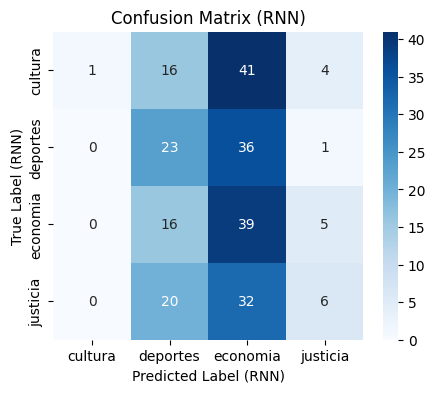

In [21]:
# 5. Predecir en el conjunto de prueba con RNN
y_pred_prob_rnn = model_rnn.predict(X_test)
y_pred_rnn = np.argmax(y_pred_prob_rnn, axis=1)
y_true = np.argmax(y_test, axis=1)

# 6. Obtener el reporte de clasificación para RNN
report_rnn = classification_report(y_true, y_pred_rnn, target_names=y_encoder.label_encoder.classes_)
print("\nReporte de Clasificación (RNN):\n", report_rnn)

# 7. Calcular y mostrar las métricas adicionales para RNN
accuracy_rnn = accuracy_score(y_true, y_pred_rnn)
precision_rnn = precision_score(y_true, y_pred_rnn, average='weighted')
recall_rnn = recall_score(y_true, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_true, y_pred_rnn, average='weighted')

print("\nMétricas Adicionales (RNN):")
print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1 Score: {f1_rnn:.4f}")

# 8. Matriz de confusión para RNN
conf_matrix_rnn = confusion_matrix(y_true, y_pred_rnn)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_rnn, annot=True, cmap='Blues', fmt='g', xticklabels=y_encoder.label_encoder.classes_, yticklabels=y_encoder.label_encoder.classes_)
plt.xlabel('Predicted Label (RNN)')
plt.ylabel('True Label (RNN)')
plt.title('Confusion Matrix (RNN)')
plt.show()


#### LSTM

In [28]:
# 1. Crear el modelo LSTM
model_lstm = Sequential([
    Embedding(input_dim=len(text_pipeline.named_steps['tokenizer'].get_word_index())+1, output_dim=8, input_length=text_pipeline.named_steps['tokenizer'].max_sequence_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(len(y_encoder.label_encoder.classes_), activation='softmax')
])

# 2. Compilar el modelo LSTM
model_lstm.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Entrenar el modelo LSTM
model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# 4. Mostrar resumen del modelo LSTM
model_lstm.summary()

Epoch 1/5


c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 881ms/step - accuracy: 0.2513 - loss: 1.3875 - val_accuracy: 0.2188 - val_loss: 1.3882
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 937ms/step - accuracy: 0.2496 - loss: 1.3862 - val_accuracy: 0.2188 - val_loss: 1.3883
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 948ms/step - accuracy: 0.2859 - loss: 1.3855 - val_accuracy: 0.2240 - val_loss: 1.3878
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 990ms/step - accuracy: 0.2544 - loss: 1.3859 - val_accuracy: 0.2188 - val_loss: 1.3884
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2225 - loss: 1.3859 - val_accuracy: 0.2188 - val_loss: 1.3886


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (32, 2768, 8)          │       228,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 64)               │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,050 (1.89 MB)

 Trainable params: 247,524 (966.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 247,526 (966.90 KB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step

Reporte de Clasificación (LSTM):
               precision    recall  f1-score   support

     cultura       0.00      0.00      0.00        62
    deportes       0.25      1.00      0.40        60
    economia       0.00      0.00      0.00        60
    justicia       0.00      0.00      0.00        58

    accuracy                           0.25       240
   macro avg       0.06      0.25      0.10       240
weighted avg       0.06      0.25      0.10       240


Métricas Adicionales (LSTM):
Accuracy: 0.2500
Precision: 0.0625
Recall: 0.2500
F1 Score: 0.1000


c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

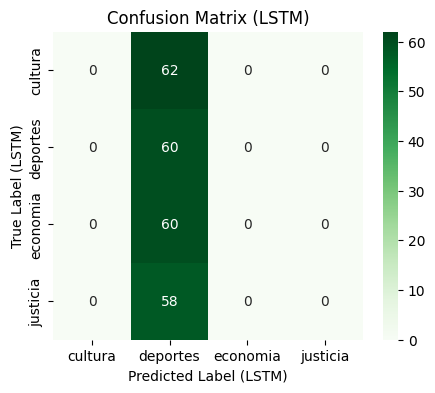

In [29]:
# 5. Predecir en el conjunto de prueba con LSTM
y_pred_prob_lstm = model_lstm.predict(X_test)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

# 6. Obtener el reporte de clasificación para LSTM
report_lstm = classification_report(y_true, y_pred_lstm, target_names=y_encoder.label_encoder.classes_)
print("\nReporte de Clasificación (LSTM):\n", report_lstm)

# 7. Calcular y mostrar las métricas adicionales para LSTM
accuracy_lstm = accuracy_score(y_true, y_pred_lstm)
precision_lstm = precision_score(y_true, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_true, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_true, y_pred_lstm, average='weighted')

print("\nMétricas Adicionales (LSTM):")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1 Score: {f1_lstm:.4f}")

# 8. Matriz de confusión para LSTM
conf_matrix_lstm = confusion_matrix(y_true, y_pred_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_lstm, annot=True, cmap='Greens', fmt='g', xticklabels=y_encoder.label_encoder.classes_, yticklabels=y_encoder.label_encoder.classes_)
plt.xlabel('Predicted Label (LSTM)')
plt.ylabel('True Label (LSTM)')
plt.title('Confusion Matrix (LSTM)')
plt.show()



In [26]:
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)


Forma de y_train: (960, 4)
Forma de y_test: (240, 4)


In [27]:
print("Distribución de etiquetas en el conjunto de entrenamiento:")
print(pd.Series(Df_pre['Etiqueta']).value_counts())


Distribución de etiquetas en el conjunto de entrenamiento:
Etiqueta
cultura     300
deportes    300
economia    300
justicia    300
Name: count, dtype: int64


In [25]:
print("Tamaño del vocabulario (LSTM):", len(text_pipeline.named_steps['tokenizer'].get_word_index()) + 1)
print("Longitud máxima de secuencia (LSTM):", text_pipeline.named_steps['tokenizer'].max_sequence_len)


Tamaño del vocabulario (LSTM): 28572
Longitud máxima de secuencia (LSTM): 2768


#### Preguntas
- Es necesario balancear los datos por cada categoría no estaria generando perdida de información
- Porque no me toma los 1200 comentarios
- Como lograr aumentar el accuracy del modelo